# Process UrbanSound8k

## Resources
* librosa: https://librosa.org/doc/latest/index.html

## Import modules

In [21]:
import IPython as ip

import os 
from glob import glob
import multiprocessing as mp

import torch
import torchaudio
import torchvision
from PIL import Image

import numpy as np
import pandas as pd
from random import randint

import librosa
import librosa.display
import sounddevice as sd
import soundfile as sf

import matplotlib
import matplotlib.pyplot as plt

## Declare paths

In [2]:
data_path = 'UrbanSound8k'
audio_path = 'audio'
meta_path = 'metadata'

In [3]:
bn_street_1 = 'background_noise/background_noise_150993__saphe__street-scene-1.wav'
bn_street_2 = 'background_noise/207208__jormarp__high-street-of-gandia-valencia-spain.wav'
bn_park = 'background_noise/268903__yonts__city-park-tel-aviv-israel.wav'
bn_street_3 ='background_noise/173955__saphe__street-scene-3.wav'
bn_paths = [bn_street_1,bn_street_2,bn_park,bn_street_3]

## Inspect metadata

In [4]:
meta_data = pd.read_csv(data_path+'/'+meta_path+'/UrbanSound8K.csv')
meta_data['duration'] = meta_data['end']-meta_data['start']
print(meta_data.head())

      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  duration  
0          dog_bark  0.317551  
1  children_playing  4.000000  
2  children_playing  4.000000  
3  children_playing  4.000000  
4  children_playing  4.000000  


In [5]:
meta_data.groupby(['classID','class']).size().reset_index().rename(columns={0:'count'})

,classID,class,count
0,0,air_conditioner,1000
1,1,car_horn,429
2,2,children_playing,1000
3,3,dog_bark,1000
4,4,drilling,1000
5,5,engine_idling,1000
6,6,gun_shot,374
7,7,jackhammer,1000
8,8,siren,929
9,9,street_music,1000


In [6]:
print(meta_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
 8   duration         8732 non-null   float64
dtypes: float64(3), int64(4), object(2)
memory usage: 614.1+ KB
None


dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
drilling            1000
engine_idling       1000
jackhammer          1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64


<AxesSubplot:title={'center':'class dist.'}>

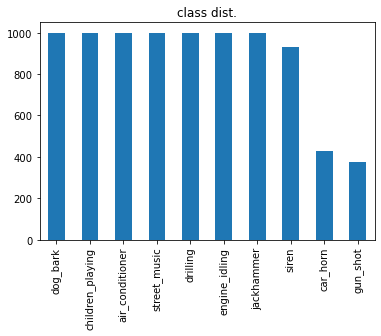

In [7]:
print(meta_data['class'].value_counts())
meta_data['class'].value_counts().plot(kind='bar',title='class dist.')

## Inspect audio files

In [8]:
audio_folders = glob(data_path+"/"+audio_path+"/f*")
audio_files = {}
for folder in sorted(audio_folders):
    audio_files[folder.split("/")[-1]] = glob(folder+"/*.wav")
n_samples = sum([len(audio_files[k]) for k in audio_files.keys()])
print("Number of samples: {}".format(n_samples))

Number of samples: 8732


In [9]:
def playAudioSample(sample_path):
    ''' Reads .wav file as np.array '''
    data, fs = sf.read(sample_path, dtype='float32') 
    sd.play(data, fs)
    status = sd.wait() 
    
def getSoundClass(sample_path,meta_data):
    row = meta_data[meta_data['slice_file_name'] == sample_path]
    return row['class'].values

In [10]:
print("Class: {}".format(getSoundClass(audio_files['fold1'][0].split("/")[-1],meta_data)))
playAudioSample(audio_files['fold1'][0])

Class: ['children_playing']


In [11]:
print("Class: {}".format(getSoundClass(audio_files['fold1'][1].split("/")[-1],meta_data)))
playAudioSample(audio_files['fold1'][1])

Class: ['gun_shot']


In [12]:
print("Class: {}".format(getSoundClass(audio_files['fold1'][2].split("/")[-1],meta_data)))
playAudioSample(audio_files['fold1'][2])

Class: ['air_conditioner']


## Resample at 22.5 kHz

In [ ]:
new_sample_rate_dir = data_path+'/'+'audio_22_5_kHz'
if not os.path.isdir(new_sample_rate_dir):
    os.mkdir(new_sample_rate_dir)

In [ ]:
def resampleWAV(wav_path,new_dir,new_sr=22500):
    fold_name, wav_name = wav_path.split('/')[-2:]
    new_wav_name = new_dir+"/"+fold_name+"/"+wav_name
    if not os.path.isdir(new_dir+"/"+fold_name):
        os.mkdir(new_dir+"/"+fold_name)
    y, sr = librosa.load(wav_path, sr=new_sr)
    sf.write(new_wav_name, y, sr)
    
for key, files in enumerate(audio_files):
    [resampleWAV(file,new_sample_rate_dir) for file in audio_files[files]]

## Data Augment Methods

### Add Background Noise

In [13]:
def add_background_noise(y,bn):
    # Sample uniform for loudness of noise
    w = np.random.uniform(.1,.5)
    # Get length of noise and audio 
    bn_len = bn.shape[0]
    y_len = y.shape[0]
    # Get window of noise for bn
    bn_start = randint(0,bn_len-y_len)
    bn_end = bn_start+y_len
    bn_split = bn[bn_start:bn_end]
    # Add noise
    z = (1-w)*y+w*bn_split
    return z 

In [14]:
test_path = 'UrbanSound8k/audio_22_5_kHz/fold1/17913-4-0-1.wav'

In [15]:
# Load background sounds 
bn_sounds = []
for bn_path in bn_paths:
    bn, _ = librosa.load(bn_path, sr=22500)
    bn_sounds.append(bn)

In [16]:
data, fs = sf.read(test_path, dtype='float32') 
new_sound = add_background_noise(data,bn_sounds[1])
sd.play(new_sound, fs)
status = sd.wait() 

### Add Pitch Shift

In [17]:
def add_pitch_shift(y,step,sr=22500):
    y_pitch_shift = librosa.effects.pitch_shift(y, sr, n_steps=step)
    return y_pitch_shift

In [18]:
data, fs = sf.read(test_path, dtype='float32') 
new_sound = add_pitch_shift(data,1)
sd.play(new_sound, fs)
status = sd.wait() 

### Add Time Stretch

In [19]:
def add_time_stretch(y,rate):
    y_stretch = librosa.effects.time_stretch(y, rate)
    return y_stretch

In [20]:
data, fs = sf.read(test_path, dtype='float32') 
new_sound = add_time_stretch(data,.5)
sd.play(new_sound, fs)
status = sd.wait() 

### Overlap audio samples 

In [ ]:
y1, sample_rate1 = librosa.load(audio_files['fold2'][0],mono=True) 
#y1 *= .1 # makes sound quieter
sd.play(y1, sample_rate1)
status = sd.wait() 

In [ ]:
y2, sample_rate2  = librosa.load(audio_files['fold2'][1],mono=True, dtype='float32') 
#y2 *= .1 # makes sound quieter
sd.play(y2, sample_rate2)
status = sd.wait() 

In [ ]:
# MERGE
if y1.shape[0] > y2.shape[0]:
    y1 = y1[:y2.shape[0]]
else:
    y2 = y2[:y1.shape[0]]
    
librosa.display.waveplot((y1+y2)/2, sr=int((sample_rate1+sample_rate2)/2))

# REPRODUCE
ip.display.Audio((y1+y2)/2, rate=int((sample_rate1+sample_rate2)/2))

In [ ]:
# SAVE
sf.write('overlap_demo.wav', (y1+y2)/2, int((sample_rate1+sample_rate2)/2), 'PCM_24')

## Make spectrograms

In [22]:
def make_MelSpectrogram(clip,sr=22050):
    num_channels = 3
    window_sizes = [25, 50, 100]
    hop_sizes = [10, 25, 50]

    # Zero-padding for clip(size <= 2205)
    if len(clip) <= 2205:
        clip = np.concatenate((clip, np.zeros(2205 - len(clip) + 1)))

    specs = []
    for i in range(num_channels):
        window_length = int(round(window_sizes[i]*sr/1000))
        hop_length = int(round(hop_sizes[i]*sr/1000))
        clip = torch.Tensor(clip)
        spec = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_fft=2205, win_length=window_length, hop_length=hop_length, n_mels=128)(clip)
        eps = 1e-6
        spec = spec.numpy()
        spec = np.log(spec+ eps)
        spec = np.asarray(torchvision.transforms.Resize((128, 250))(Image.fromarray(spec)))
        # Scale between [0,1]
        spec = (spec - np.min(spec))/np.ptp(spec)
        specs.append(spec)
    specs = np.array(specs)
    specs = np.moveaxis(specs, 0, 2)
    return specs 

In [23]:
data, fs = sf.read(test_path, dtype='float32') 
data_spect = make_MelSpectrogram(data)

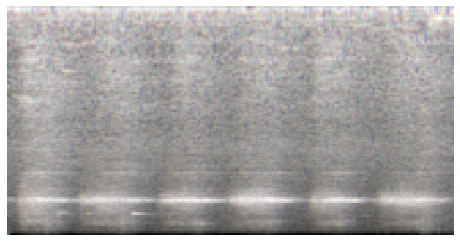

In [24]:
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(data_spect, interpolation='nearest') 

In [25]:
matplotlib.image.imsave('test_spect.png', data_spect)

# Make DataSet
## This takes a long time :(

### Read 22.5 kHz wav file names

In [26]:
audio_folders = glob(data_path+"/audio_22_5_kHz"+"/f*")
audio_files = {}
for folder in sorted(audio_folders):
    audio_files[folder.split("/")[-1]] = glob(folder+"/*.wav")
n_samples = sum([len(audio_files[k]) for k in audio_files.keys()])
print("Number of samples: {}".format(n_samples))

Number of samples: 8732


### Normal Dataset

In [ ]:
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))

if not os.path.isdir(data_path+'/audio_22_5_spect'):
    os.mkdir(data_path+'/audio_22_5_spect')

for k in audio_files.keys():
    if not os.path.isdir(data_path+'/audio_22_5_spect/'+k):
        os.mkdir(data_path+'/audio_22_5_spect/'+k)
    for wav_file in audio_files[k]:
        file_name = wav_file.split("/")[-1].split(".")[0]
        new_path = data_path+'/audio_22_5_spect/'+k+"/"+file_name+".png"              
        data, fs = sf.read(wav_file, dtype='float32') 
        data_spect = make_MelSpectrogram(data)
        matplotlib.image.imsave(new_path, data_spect)

### Augment Dataset

In [ ]:
if not os.path.isdir(data_path+'/audio_22_5_spect_aug'):
    os.mkdir(data_path+'/audio_22_5_spect_aug')

def augmentData(k):
    if not os.path.isdir(data_path+'/audio_22_5_spect_aug/'+k):
        os.mkdir(data_path+'/audio_22_5_spect_aug/'+k)
    for wav_file in audio_files[k]:
        file_name = wav_file.split("/")[-1].split(".")[0]
        new_path = data_path+'/audio_22_5_spect_aug/'+k+"/"+file_name            
        data, fs = sf.read(wav_file, dtype='float32') 
        
        # Add background noises 1
        new_data = add_background_noise(data,bn_sounds[0])
        data_spect = make_MelSpectrogram(new_data)
        matplotlib.image.imsave(new_path+"^bn1.png", data_spect)
        
        # Add background noises 2
        new_data = add_background_noise(data,bn_sounds[1])
        data_spect = make_MelSpectrogram(new_data)
        matplotlib.image.imsave(new_path+"^bn2.png", data_spect)
        
        # Add background noises 3
        new_data = add_background_noise(data,bn_sounds[2])
        data_spect = make_MelSpectrogram(new_data)
        matplotlib.image.imsave(new_path+"^bn3.png", data_spect)
        
        # Add background noises 4
        new_data = add_background_noise(data,bn_sounds[3])
        data_spect = make_MelSpectrogram(new_data)
        matplotlib.image.imsave(new_path+"^bn4.png", data_spect)
        
        # Add pitch shift -3.5
        new_data = add_pitch_shift(data,-3.5)
        data_spect = make_MelSpectrogram(new_data)
        matplotlib.image.imsave(new_path+"^ps_n3h.png", data_spect)
        
        # Add pitch shift -2.5
        new_data = add_pitch_shift(data,-2.5)
        data_spect = make_MelSpectrogram(new_data)
        matplotlib.image.imsave(new_path+"^ps_n2h.png", data_spect)

        # Add pitch shift -2
        new_data = add_pitch_shift(data,-2)
        data_spect = make_MelSpectrogram(new_data)
        matplotlib.image.imsave(new_path+"^ps_n2.png", data_spect)
        
        # Add pitch shift -1
        new_data = add_pitch_shift(data,-1)
        data_spect = make_MelSpectrogram(new_data)
        matplotlib.image.imsave(new_path+"^ps_n1.png", data_spect)
        
        # Add pitch shift 1
        new_data = add_pitch_shift(data,1)
        data_spect = make_MelSpectrogram(new_data)
        matplotlib.image.imsave(new_path+"^ps_1.png", data_spect)
        
        # Add pitch shift 2
        new_data = add_pitch_shift(data,2)
        data_spect = make_MelSpectrogram(new_data)
        matplotlib.image.imsave(new_path+"^ps_2.png", data_spect)
        
        # Add pitch shift 2.5
        new_data = add_pitch_shift(data,2.5)
        data_spect = make_MelSpectrogram(new_data)
        matplotlib.image.imsave(new_path+"^ps_2h.png", data_spect)
        
        # Add pitch shift 3.5
        new_data = add_pitch_shift(data,3.5)
        data_spect = make_MelSpectrogram(new_data)
        matplotlib.image.imsave(new_path+"^ps_3h.png", data_spect)
        
        # Add time shift .81 
        new_data = add_time_stretch(data,.81)
        data_spect = make_MelSpectrogram(new_data)
        matplotlib.image.imsave(new_path+"^ts_81.png", data_spect)
        
        # Add time shift .93 
        new_data = add_time_stretch(data,.93)
        data_spect = make_MelSpectrogram(new_data)
        matplotlib.image.imsave(new_path+"^ts_93.png", data_spect)
        
        # Add time shift 1.07
        new_data = add_time_stretch(data,1.07)
        data_spect = make_MelSpectrogram(new_data)
        matplotlib.image.imsave(new_path+"^ts_107.png", data_spect)
        
        # Add time shift 1.23
        new_data = add_time_stretch(data,1.23)
        data_spect = make_MelSpectrogram(new_data)
        matplotlib.image.imsave(new_path+"^ts_123.png", data_spect)
        
pool = mp.Pool(processes=mp.cpu_count()) 
pool.map(augmentData, list(audio_files.keys()))